# DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 

Version 3.24

[Andreas Loukas](https://andreasloukas.wordpress.com/), [EPFL LTS2](https://lts2.epfl.ch/), [Michaël Defferrard](http://deff.ch)

Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, 
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - 
Daily (GHCN-Daily), Version 3. 

The five core features are:

* PRCP = Precipitation (tenths of mm)
* SNOW = Snowfall (mm)
* SNWD = Snow depth (mm)
* TMAX = Maximum temperature (tenths of degrees C)
* TMIN = Minimum temperature (tenths of degrees C)

The other features are:

* ACMC = Average cloudiness midnight to midnight from 30-second ceilometer data (percent)
* ACMH = Average cloudiness midnight to midnight from manual observations (percent)
* ACSC = Average cloudiness sunrise to sunset from 30-second ceilometer data (percent)
* ACSH = Average cloudiness sunrise to sunset from manual observations (percent)
* AWDR = Average daily wind direction (degrees)
* AWND = Average daily wind speed (tenths of meters per second)
* DAEV = Number of days included in the multiday evaporation total (MDEV)
* DAPR = Number of days included in the multiday precipiation total (MDPR)
* DASF = Number of days included in the multiday snowfall total (MDSF)		  
* DATN = Number of days included in the multiday minimum temperature (MDTN)
* DATX = Number of days included in the multiday maximum temperature (MDTX)
* DAWM = Number of days included in the multiday wind movement (MDWM)
* DWPR = Number of days with non-zero precipitation included in multiday precipitation total (MDPR)
* EVAP = Evaporation of water from evaporation pan (tenths of mm)
* FMTM = Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)
* FRGB = Base of frozen ground layer (cm)
* FRGT = Top of frozen ground layer (cm)
* FRTH = Thickness of frozen ground layer (cm)
* GAHT = Difference between river and gauge height (cm)
* MDEV = Multiday evaporation total (tenths of mm; use with DAEV)
* MDPR = Multiday precipitation total (tenths of mm; use with DAPR and DWPR, if available)
* MDSF = Multiday snowfall total 
* MDTN = Multiday minimum temperature (tenths of degrees C; use with DATN)
* MDTX = Multiday maximum temperature (tenths of degress C; use with DATX)
* MDWM = Multiday wind movement (km)
* MNPN = Daily minimum temperature of water in an evaporation pan (tenths of degrees C)
* MXPN = Daily maximum temperature of water in an evaporation pan (tenths of degrees C)
* PGTM = Peak gust time (hours and minutes, i.e., HHMM)
* PSUN = Daily percent of possible sunshine (percent)
* SN*# = Minimum soil temperature (tenths of degrees C) where * corresponds to a code for ground cover and # corresponds to a code for soil depth. For ground cover and depth codes see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
* SX*# = Maximum soil temperature (tenths of degrees C)  where * corresponds to a code for ground cover  and # corresponds to a code for soil depth.  See SN*# for ground cover and depth codes. 
* TAVG = Average temperature (tenths of degrees C) [Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight]
* THIC = Thickness of ice on water (tenths of mm)	
* TOBS = Temperature at the time of observation (tenths of degrees C)
* TSUN = Daily total sunshine (minutes)
* WDF1 = Direction of fastest 1-minute wind (degrees)
* WDF2 = Direction of fastest 2-minute wind (degrees)
* WDF5 = Direction of fastest 5-second wind (degrees)
* WDFG = Direction of peak wind gust (degrees)
* WDFI = Direction of highest instantaneous wind (degrees)
* WDFM = Fastest mile wind direction (degrees)
* WDMV = 24-hour wind movement (km)	   
* WESD = Water equivalent of snow on the ground (tenths of mm)
* WESF = Water equivalent of snowfall (tenths of mm)
* WSF1 = Fastest 1-minute wind speed (tenths of meters per second)
* WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
* WSF5 = Fastest 5-second wind speed (tenths of meters per second)
* WSFG = Peak gust wind speed (tenths of meters per second)
* WSFI = Highest instantaneous wind speed (tenths of meters per second)
* WSFM = Fastest mile wind speed (tenths of meters per second)
* WT** = Weather Type. For numeric codes ** see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
* WV** = Weather in the Vicinity. For numeric codes ** see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)

[FTP link](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

In [4]:
datapath = "/mnt/nas/LTS2/datasets/ghcn-daily/processed/"
rawpath = "/mnt/nas/LTS2/datasets/ghcn-daily/raw/"
newdatapath = "../data/ghcn-daily/processed/"

In [5]:
years = np.arange(2010,2015)

feature_names = ['PRCP', 'TMIN', 'TMAX', 'SNOW']
n_features = len(feature_names)
n_years  = len(years)

## Station

In [6]:
filename = 'stations_{:4d}-{:4d}.npz'.format(years[0], years[-1])

# only recompute if necessary
if not os.path.isfile(datapath+filename):
    print('Problem occured')
    raise ValueError()
    
    # Variable   Columns   Type
    # ID            1-11   Character
    # LATITUDE     13-20   Real
    # LONGITUDE    22-30   Real
    # ELEVATION    32-37   Real
    # STATE        39-40   Character
    # NAME         42-71   Character
    # GSN FLAG     73-75   Character
    # HCN/CRN FLAG 77-79   Character
    # WMO ID       81-85   Character

    id_ghcn, lat, lon, elev, name = [], [], [], [], []
    with open('raw/ghcnd-stations.txt', 'r') as f:
        for line in f:

            iid, ilat, ilon, ielev, iname = line[0:11], line[12:20], line[21:30], line[31:37], line[41:71]         
            # state, GSN_flag, HCNCRN_flag, WMO_id = line[38:40], line[72:75], line[76:79], line[80:85] 

            assert (not iid.isspace()) and (not ilat.isspace()) and (not ilon.isspace()) \
                and (not ielev.isspace()) and (not iname.isspace())

            id_ghcn.append(iid.strip())
            lat.append(float(ilat.strip()))
            lon.append(float(ilon.strip()))
            elev.append(float(ielev.strip()))
            name.append(iname.strip())

    id_ghcn, lat, lon, elev, name = np.array(id_ghcn), np.array(lat), np.array(lon), np.array(elev), np.array(name)

    # Identify *relevant* stations: These are stations giving measurements in the years of interest
    # that also have known coordinates.

    # first, construct the set of all ghcn identifiers encountered in daily
    id_ghcn_relevant = set([])

    for yearIdx,year in enumerate(years):

        filename2 = 'raw/{:4}.csv.gz'.format(year)
        print('- pre-parsing : {}'.format(filename2))

        df = pd.read_csv(filename2, names=['id_ghcn', 'date', 'type', 'value', '?0', '?1', '?2', '?3'], \
                         nrows=None, usecols=[0,1,2,3])


        id_ghcn_relevant |= set(df["id_ghcn"].values)

    # second, find identifiers both in id_ghcn and id_ghcn_relevant
    id_ghcn_relevant = set(id_ghcn) & id_ghcn_relevant

    # third, keep only relevant station data 
    keep = [id in id_ghcn_relevant for id in id_ghcn] 
    id_ghcn, lat, lon, elev, name = id_ghcn[keep], lat[keep], lon[keep], elev[keep], name[keep] 

    # free up some memory
    del id_ghcn_relevant, keep

    np.savez_compressed(filename, id_ghcn=id_ghcn, lat=lat, lon=lon, elev=elev, name=name, years=years)
    
else:
    station_file = np.load(datapath+filename)
    id_ghcn, lat, lon, elev, name = station_file['id_ghcn'], station_file['lat'], station_file['lon'], station_file['elev'], station_file['name']
    del station_file
    
n_stations = id_ghcn.shape[0]
print('{} weather stations identified.'.format(n_stations))

#  a dictionary mapping GHCN ids to local ids (rows in id array) 
ghcn_to_local = dict(zip(id_ghcn, np.arange(n_stations)))

50469 weather stations identified.


## Data

In [7]:
#feature_name = 'TMAX'
# feature_names
filenames = []
datas = []
valid_days_list = []
n_stations_list = []
for feature_name in feature_names:
    filenames.append('data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], feature_name))
    print(f'- Checking if file {filenames[-1]} exists..')

    # only recompute if necessary
    if not os.path.isfile(datapath+filenames[-1]):

        print('- The file is not there. Parsing everything from raw. This will take a while.')
        # Load the station measurements into a year-list of dataframes
        df_years = []

        for yearIdx,year in enumerate(years):

            filename_year = 'raw/{:4}.csv.gz'.format(year)
            print(' - parsing *{}*'.format(filename_year))

            df = pd.read_csv(filename_year, names=['id_ghcn', 'date', 'type', 'value', '?0', '?1', '?2', '?3'], \
                             nrows=None, usecols=[0,1,2,3])

            # create a new column with the id_local
            id_local = [ghcn_to_local.get(id_g) for id_g in df["id_ghcn"].values]
            id_local = [-1 if v is None else v for v in id_local]
            id_local = np.array(id_local).astype(np.int)

            df = df.assign(id_local=pd.Series(id_local, index=df.index).values)

            # remove measurement of stations with unknown id_local
            df = df[df.id_local != -1] 

            df_years.append(df)

        del df, id_local
        print('done!')

        # Construct one array per feature and save it to disk

        # indicate for which days we have measurements (this also deals with months of different lengths)
        valid_days = np.zeros((n_years, 12, 31), dtype=np.bool)

        for _, name in enumerate(feature_names):

            print(f' - Looking at {name}')

            data = np.zeros((n_stations, n_years, 12, 31), dtype=np.float) * np.nan

            for yearIdx,year in enumerate(years):

                df = df_years[yearIdx]
                idf = df.loc[df['type'] == name]

                print(f'  - year {year}')

                # remove measurement of stations with unknown id_local
                idf = idf[idf.id_local != -1] 

                for monthIdx,month in enumerate(range(1,12+1)): 
                    for dayIdx,day in enumerate(range(1,31+1)):        

                        date = int('{:4d}{:02d}{:02d}'.format(year,month,day))
                        jdf = idf.loc[idf['date'] == date]

                        # sort data according to the id_local 
                        jdf.set_index('id_local', inplace=True)
                        jdf = jdf.sort_index()

                        index = jdf.index.values
                        values = jdf['value'].values.astype(np.float)

                        if len(index) != 0: 
                            data[index,yearIdx,monthIdx,dayIdx] = values
                            valid_days[yearIdx,monthIdx,dayIdx] = True

            print('  - saving to disk')
            np.savez_compressed('processed/data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], name), data=data, valid_days=valid_days)

            del index, values, df, idf, jdf    

    else:    
        print('- Loading data from disk..')

        data_file = np.load(datapath+filenames[-1])
        data, valid_days = data_file['data'], data_file['valid_days']        
        n_stations = data.shape[0]
        print(f'- {n_stations} stations loaded.')
        data = data.reshape((n_stations, n_years*12*31))
        if feature_name == 'TMIN' or feature_name == 'TMAX':
            data = data.astype(np.float)
            data /= 10
        datas.append(data)
        valid_days = np.squeeze(valid_days.reshape(n_years*12*31)).astype(np.bool)
        valid_days_list.append(valid_days)
        n_stations_list.append(n_stations)

- Checking if file data_2010-2014_PRCP.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMIN.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMAX.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_SNOW.npz exists..
- Loading data from disk..
- 50469 stations loaded.


In [8]:
assert n_stations_list[0] == n_stations_list[1] == n_stations_list[2] == n_stations_list[3]

In [9]:
assert np.all(valid_days_list[0] == valid_days_list[0])
assert np.all(valid_days_list[0] == valid_days_list[1])
assert np.all(valid_days_list[0] == valid_days_list[2])
assert np.all(valid_days_list[0] == valid_days_list[3])

In [10]:
full_data = np.stack(datas, axis=2)

In [11]:
full_data = full_data[:, valid_days_list[0], :]

n_days = full_data.shape[1]

assert n_stations == full_data.shape[0]

print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 50469, n_days: 1826


In [12]:
np.all(np.isnan(datas[0]).all(axis=(1)) == np.isnan(datas[1]).all(axis=(1)))

False

In [13]:
keep = ~np.isnan(full_data).all(axis=1) # keep a station if we have at least one measurement in the period ot interest 
keep = np.all(keep, axis=1)

data = full_data[keep,:, :]
n_stations, n_days, _ = data.shape
print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 7860, n_days: 1826


In [14]:
keep_days = ~np.isnan(data).all(axis=0)
keep_days = np.all(keep_days, axis=1)
print(keep_days.shape)
print(data.shape)

(1826,)
(7860, 1826, 4)


In [15]:
temp_data = full_data[:,:,1:3]
keep_temp = ~np.isnan(temp_data).all(axis=1)
keep_temp = np.all(keep_temp, axis=1)

temp_data = temp_data[keep_temp,:, :]
n_stations, n_days, _ = temp_data.shape
print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 17233, n_days: 1826


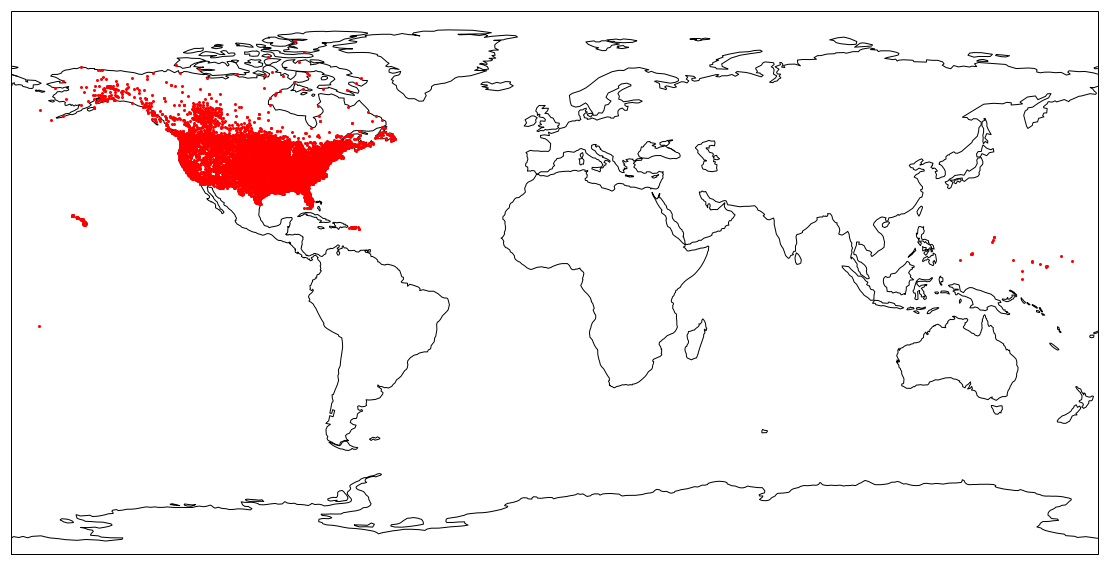

In [16]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keep], lat[keep], 'or', marker='o', markerfacecolor='r', markersize=2)


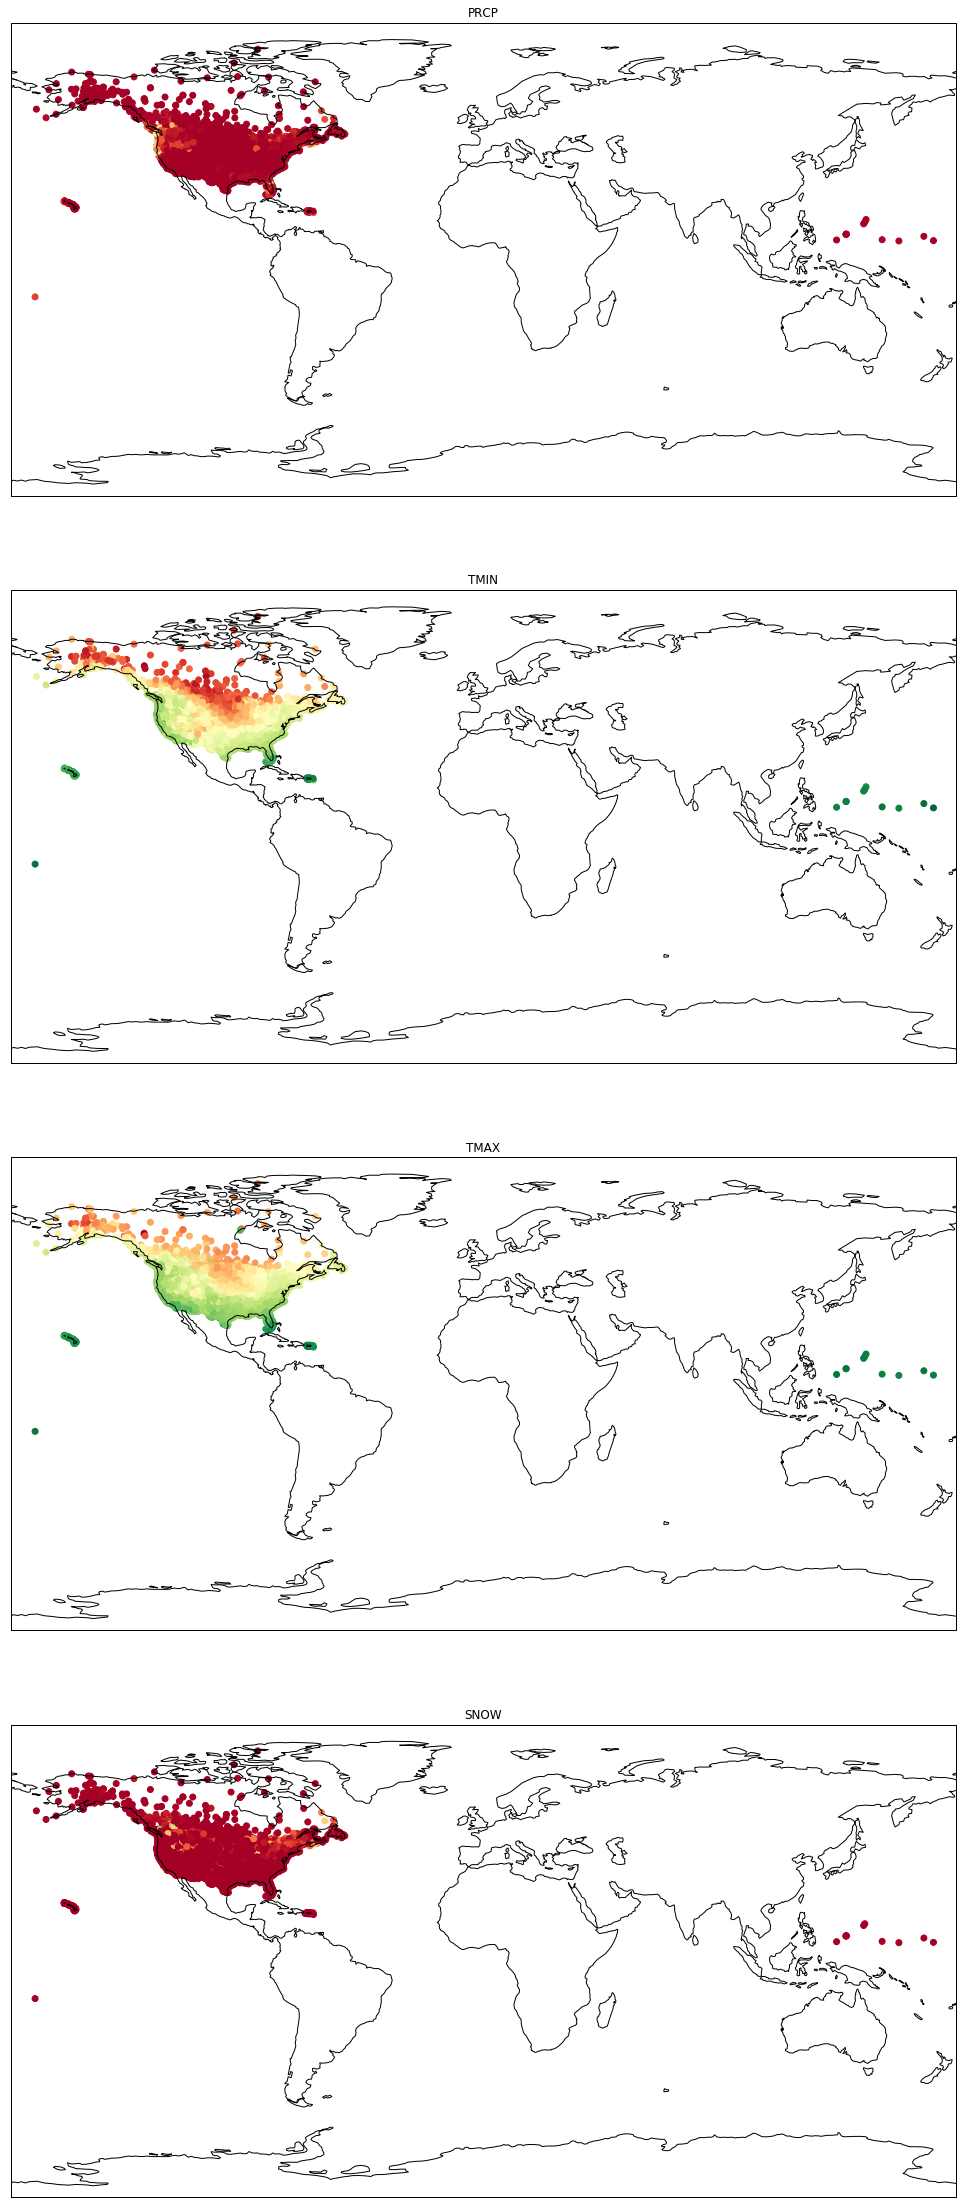

In [15]:
import cartopy.crs as ccrs

size = 40
fig = plt.figure(figsize=(2*size, 1*size))
for i in range(len(feature_names)):
    ax = fig.add_subplot(4, 1, i+1, projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.scatter(lon[keep], lat[keep], s=None, c=data[:,0,i], cmap=plt.get_cmap('RdYlGn'))
    ax.set_title(feature_names[i])

Seems to have outliers data. Can be sure to be correct (Tmax = -99 when Tmin = -8) or (Tmin = -72.8 for multiple Tmax)

In [17]:
out = np.where(data<-70)
#print(data[out[:2]])
data[out] = np.nan

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


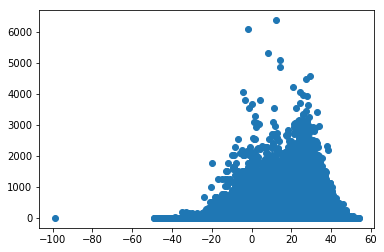

In [16]:
plt.scatter(data[:,:,2], data[:,:,0])

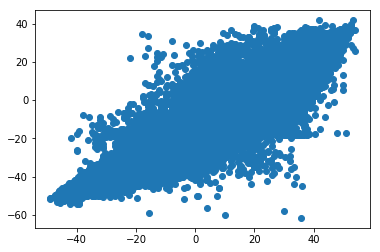

In [91]:
plt.scatter(data[:,:,2], data[:,:,1])

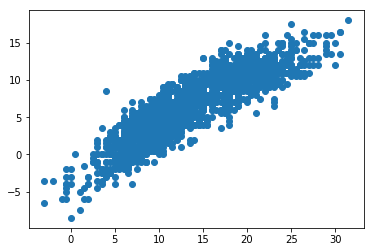

In [25]:
plt.scatter(data[9,:,2], data[9,:,1])

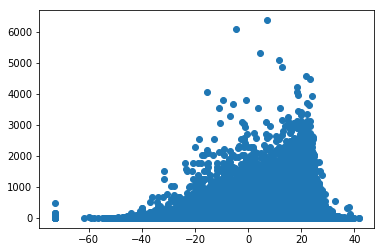

In [17]:
plt.scatter(data[:,:,1], data[:,:,0])

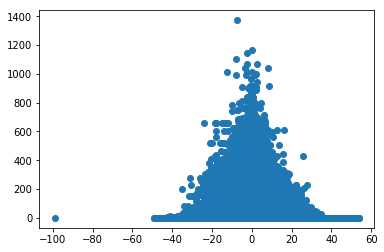

In [17]:
plt.scatter(data[:,:,2], data[:,:,3])

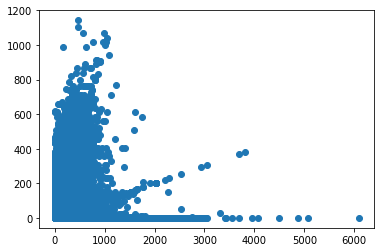

In [212]:
plt.scatter(data[:,:,0], data[:,:,3])

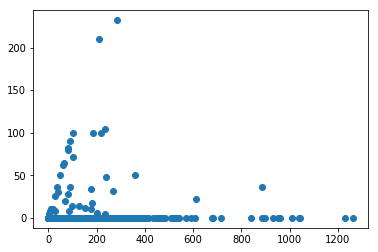

In [18]:
plt.scatter(data[3,:,0], data[3,:,3])

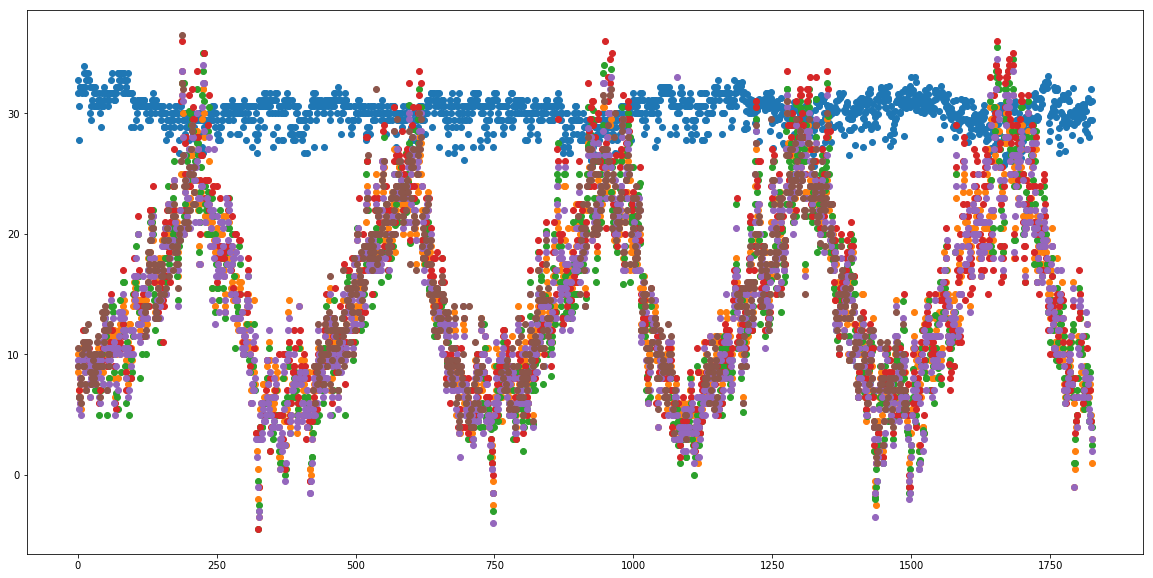

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(data[:6,:,2].T, 'o')

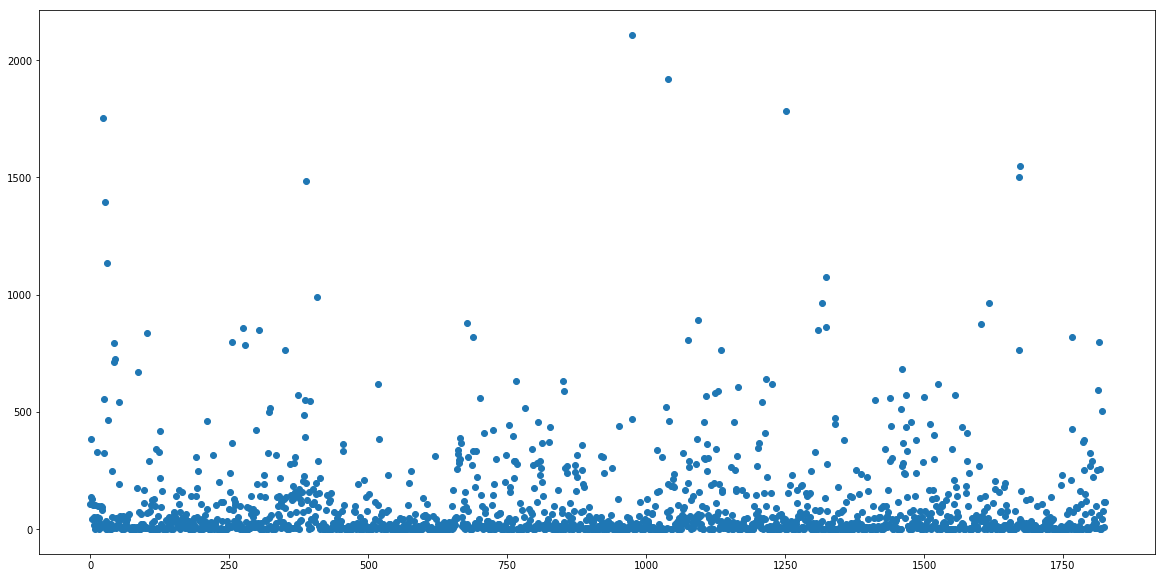

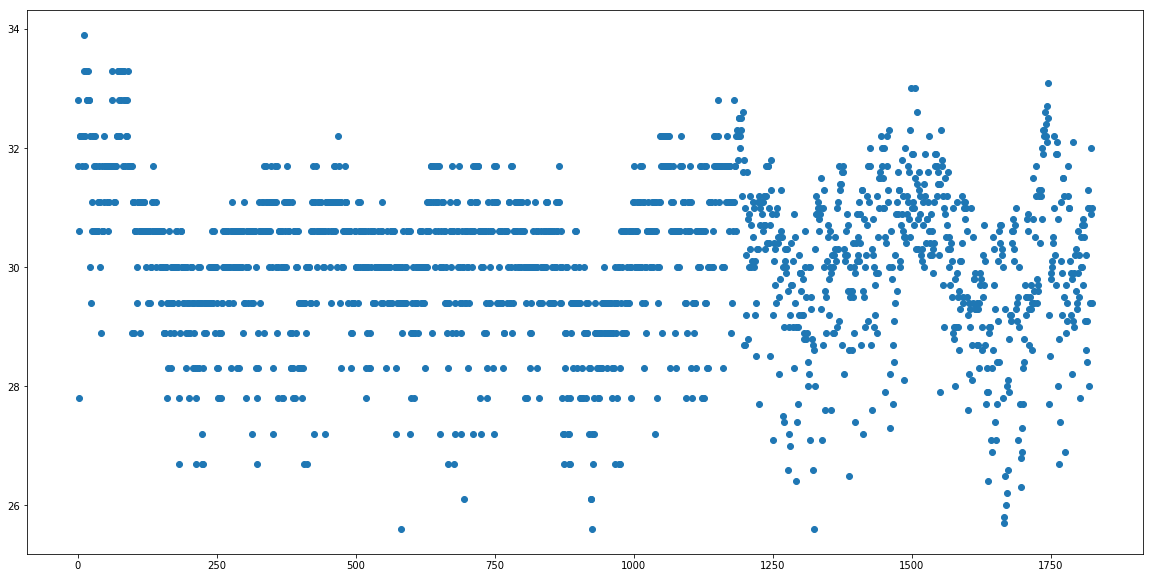

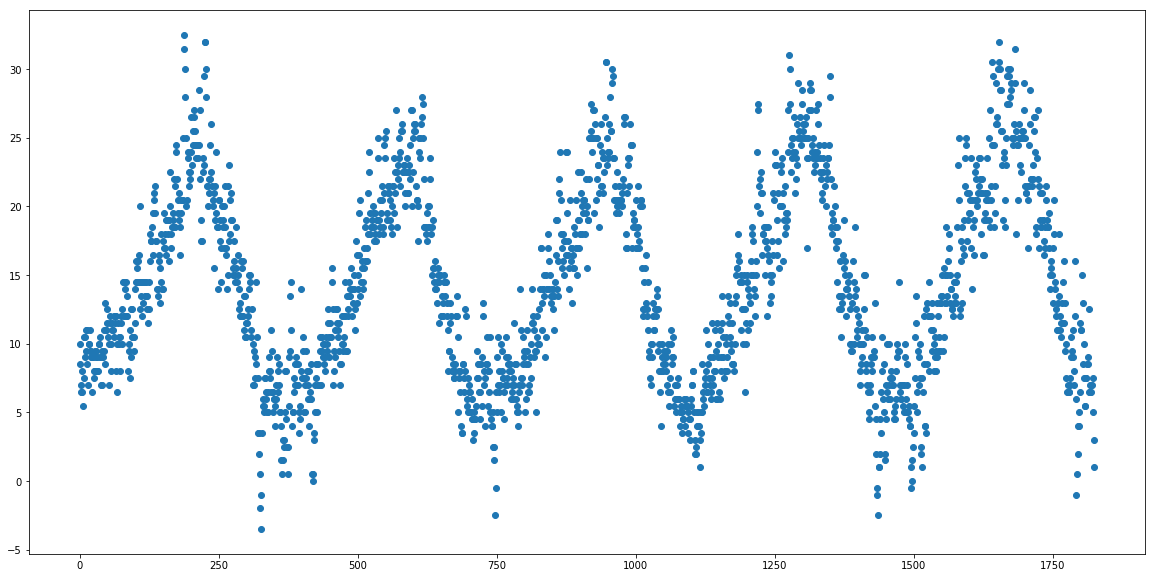

In [26]:
plt.figure(figsize=(20, 10))
plt.plot(data[0,:,0], 'o')
plt.figure(figsize=(20, 10))
plt.plot(data[0,:,2], 'o')
plt.figure(figsize=(20, 10))
plt.plot(data[1,:,2], 'o')

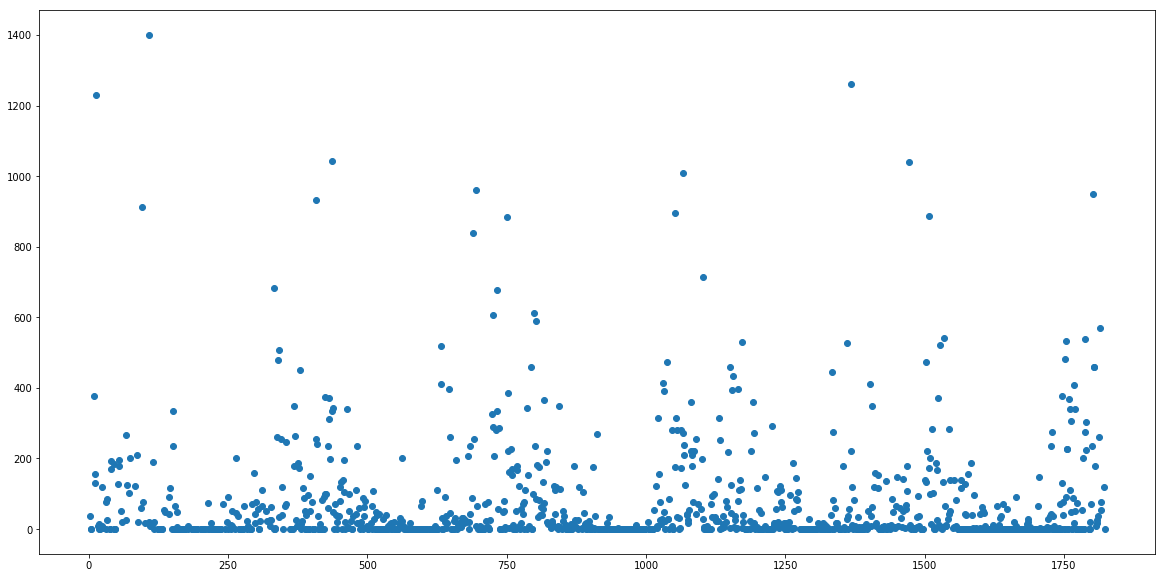

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(data[3,:,0], 'o')

In [102]:
from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph
class sphereGraph(NNGraph):
    def __init__(self, phi, theta, neighbors, rad=True, epsilon=True, **kwargs):
        if not rad:
            theta, phi = np.deg2rad(theta), np.deg2rad(phi)
        theta -= np.pi/2
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        self.coords = np.vstack([x, y, z]).T
        NNtype = 'radius' if epsilon else 'knn'
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])*0.5}
        super(sphereGraph, self).__init__(self.coords, k=neighbors, NNtype=NNtype, center=False, rescale=False,
                                     plotting=plotting, **kwargs)

In [19]:
g = sphereGraph(lon[keep], lat[keep], 100, rad=False)

2019-05-08 17:28:47,327:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


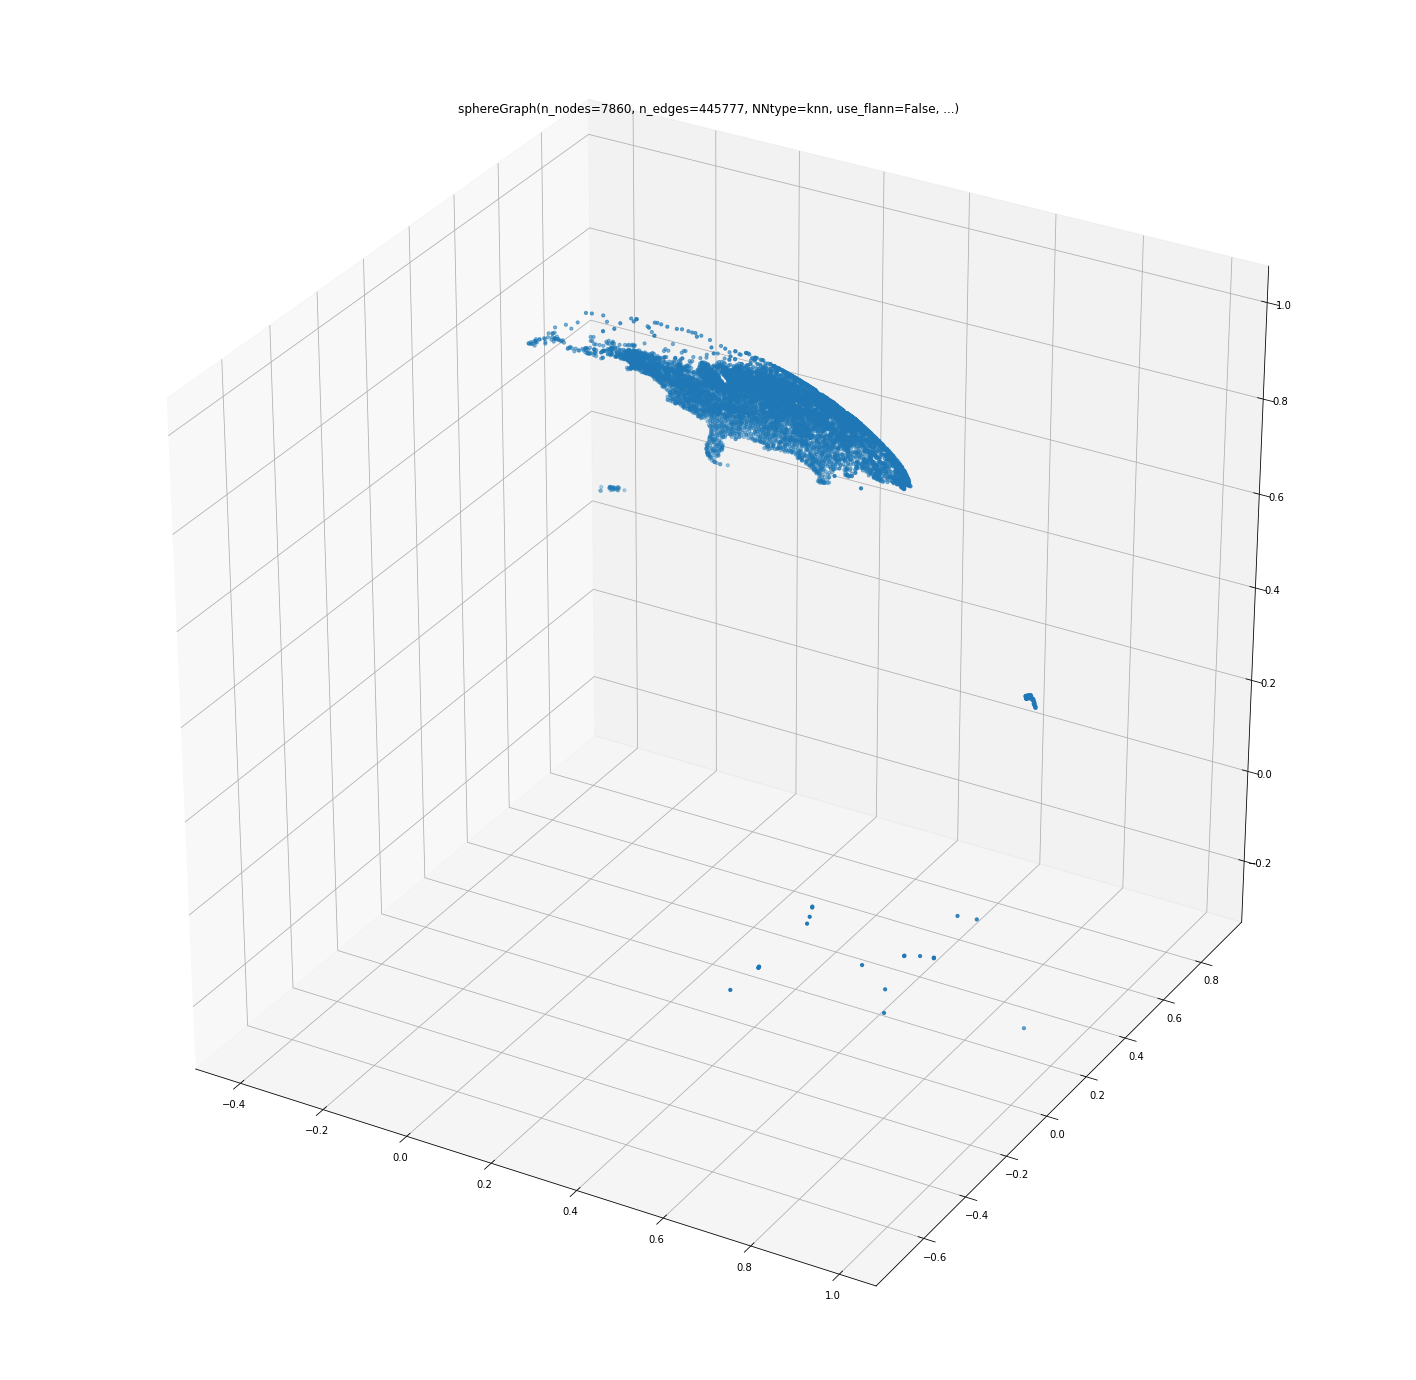

In [31]:
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
g.plot(vertex_size=10, edges=False, ax=axes)

2019-05-08 10:15:54,595:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.
2019-05-08 10:15:54,596:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (7860 x 7860) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


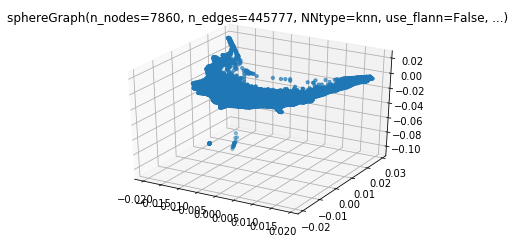

In [92]:
g.compute_laplacian("normalized")
g.compute_fourier_basis(recompute=True, n_eigenvectors=1000)
g.set_coordinates(g.U[:,1:4])
g.plot(vertex_size=10)

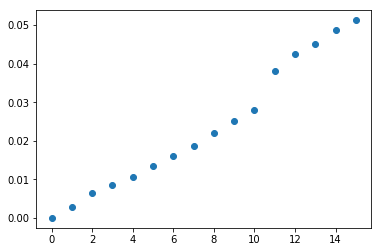

In [95]:
plt.plot(g.e[:16], 'o')

In [33]:
g_full = sphereGraph(lon, lat, 100, rad=False)

KeyboardInterrupt: 

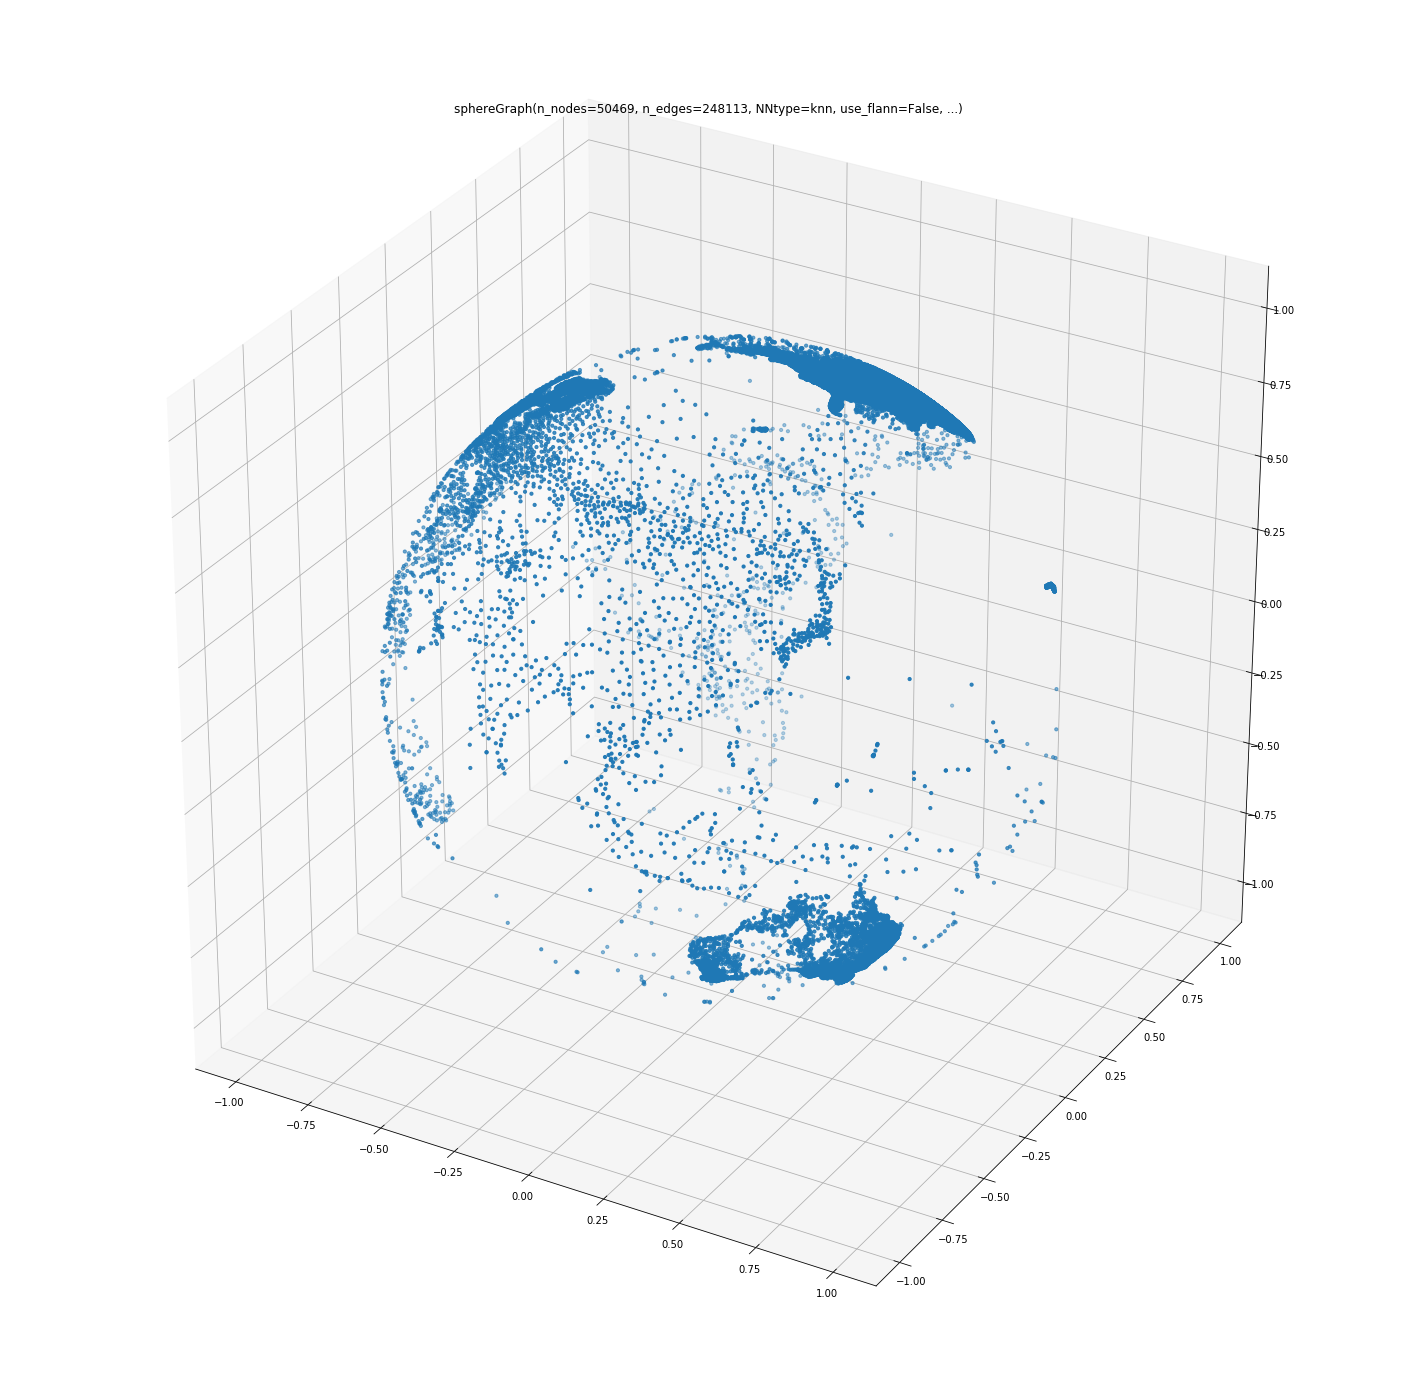

In [139]:
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
g_full.plot(vertex_size=10, edges=False, ax=axes)

2019-05-06 14:31:18,625:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the partial eigendecomposition of a large matrix (50469 x 50469) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


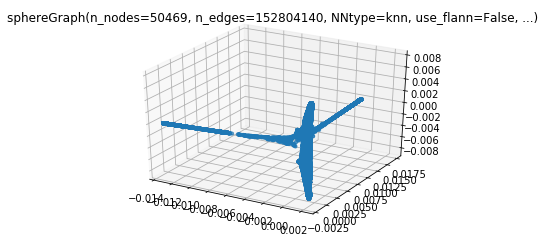

In [148]:
g_full.compute_laplacian("normalized")
g_full.compute_fourier_basis(recompute=True, n_eigenvectors=500)
g_full.set_coordinates(g_full.U[:,1:4])
g_full.plot(vertex_size=10)

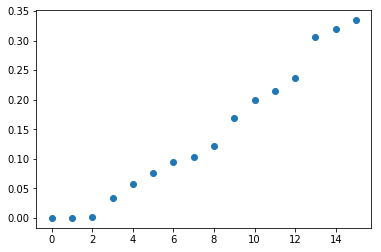

In [149]:
plt.plot(g_full.e[:16], 'o')

## inference train

In [121]:
import tensorflow as tf
params = {'L': [g.L.astype(np.float32)]*4,
          'p': [1,1,1,1],
          'F': [10, 20, 50, 1],
          'K': [5]*4,
          'batch_norm': [True]*4}
params['dir_name'] = 'GHCN_essai'
params['num_feat_in'] = 1
params['conv'] = 'chebyshev5'
params['pool'] = 'max'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 50  # Number of passes through the training data.
params['batch_size'] = 32
params['scheduler'] = lambda step: tf.train.exponential_decay(5e-1, step, decay_steps=5, decay_rate=1)
params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
n_evaluations = 200
params['eval_frequency'] = int(params['num_epochs'] * n_days / params['batch_size'] / n_evaluations)
params['M'] = []
params['regression']=True
model = models.cgcnn(**params)

NN architecture
  input: M_0 = 7860
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 7860 * 10 / 1 = 78600
    weights: F_0 * F_1 * K_1 = 1 * 10 * 5 = 50
    biases: F_1 = 10
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 7860 * 20 / 1 = 157200
    weights: F_1 * F_2 * K_2 = 10 * 20 * 5 = 1000
    biases: F_2 = 20
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 7860 * 50 / 1 = 393000
    weights: F_2 * F_3 * K_3 = 20 * 50 * 5 = 5000
    biases: F_3 = 50
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 7860 * 1 / 1 = 7860
    weights: F_3 * F_4 * K_4 = 50 * 1 * 5 = 250
    batch normalization


In [21]:
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset

Temperature MAX from Temperature MIN

In [22]:
dataset = full_data.transpose((1, 0, 2))
keepToo = ~np.isnan(dataset[:,:,1:3]).any(axis=0)
keepToo = keepToo.all(axis=1)
dataset_temp = dataset[:, keepToo, 1:3]

# remove outliers (remove outiler stations) (other option is to replace value by mean of knn)
out = np.where((dataset_temp<-60) + (dataset_temp>80))
dataset_temp = np.delete(dataset_temp, np.unique(out[1]), axis=1)
keepToo[np.argwhere(keepToo)[np.unique(out[1])]] = False

out = np.where(dataset_temp[:,:,1]==60)
dataset_temp = np.delete(dataset_temp, np.unique(out[1]), axis=1)
keepToo[np.argwhere(keepToo)[np.unique(out[1])]] = False

out = np.where((dataset_temp[:,:,0]==-35.6)*(dataset_temp[:,:,1]>0))
dataset_temp = np.delete(dataset_temp, np.unique(out[1]), axis=1)
keepToo[np.argwhere(keepToo)[np.unique(out[1])]] = False

# replace by means of neighbours (use graph)

In [23]:
print(dataset[:,keepToo,1:3].shape)
print(np.isnan(dataset[:,keepToo,1:3]).all())

(1826, 2387, 2)
False


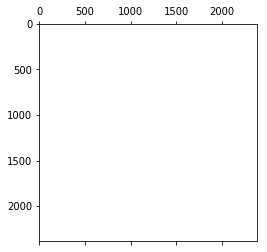

In [43]:
plt.spy(gTemp.W-gTemp.W.T)

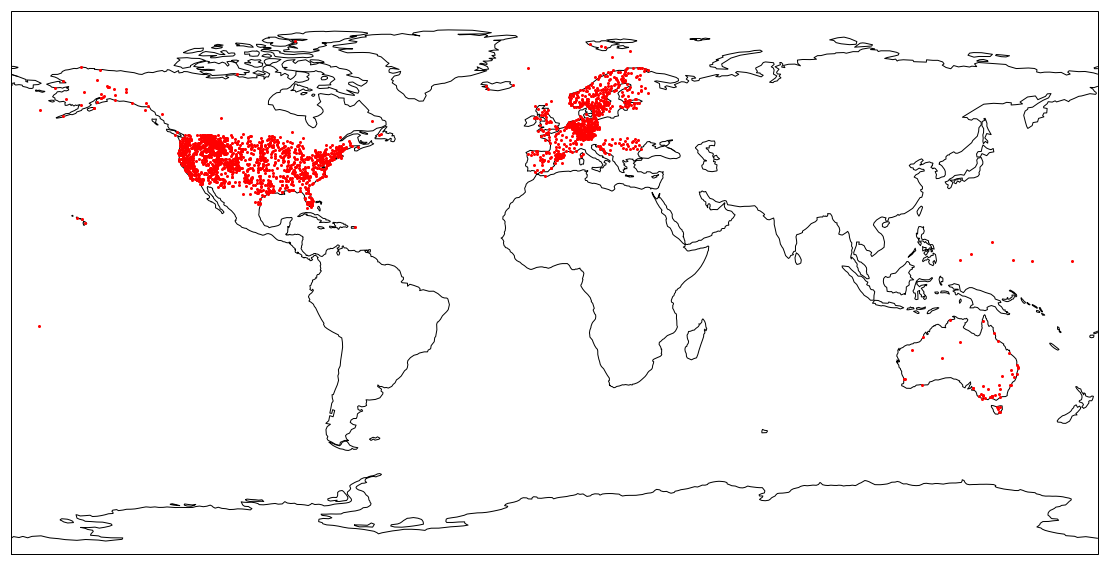

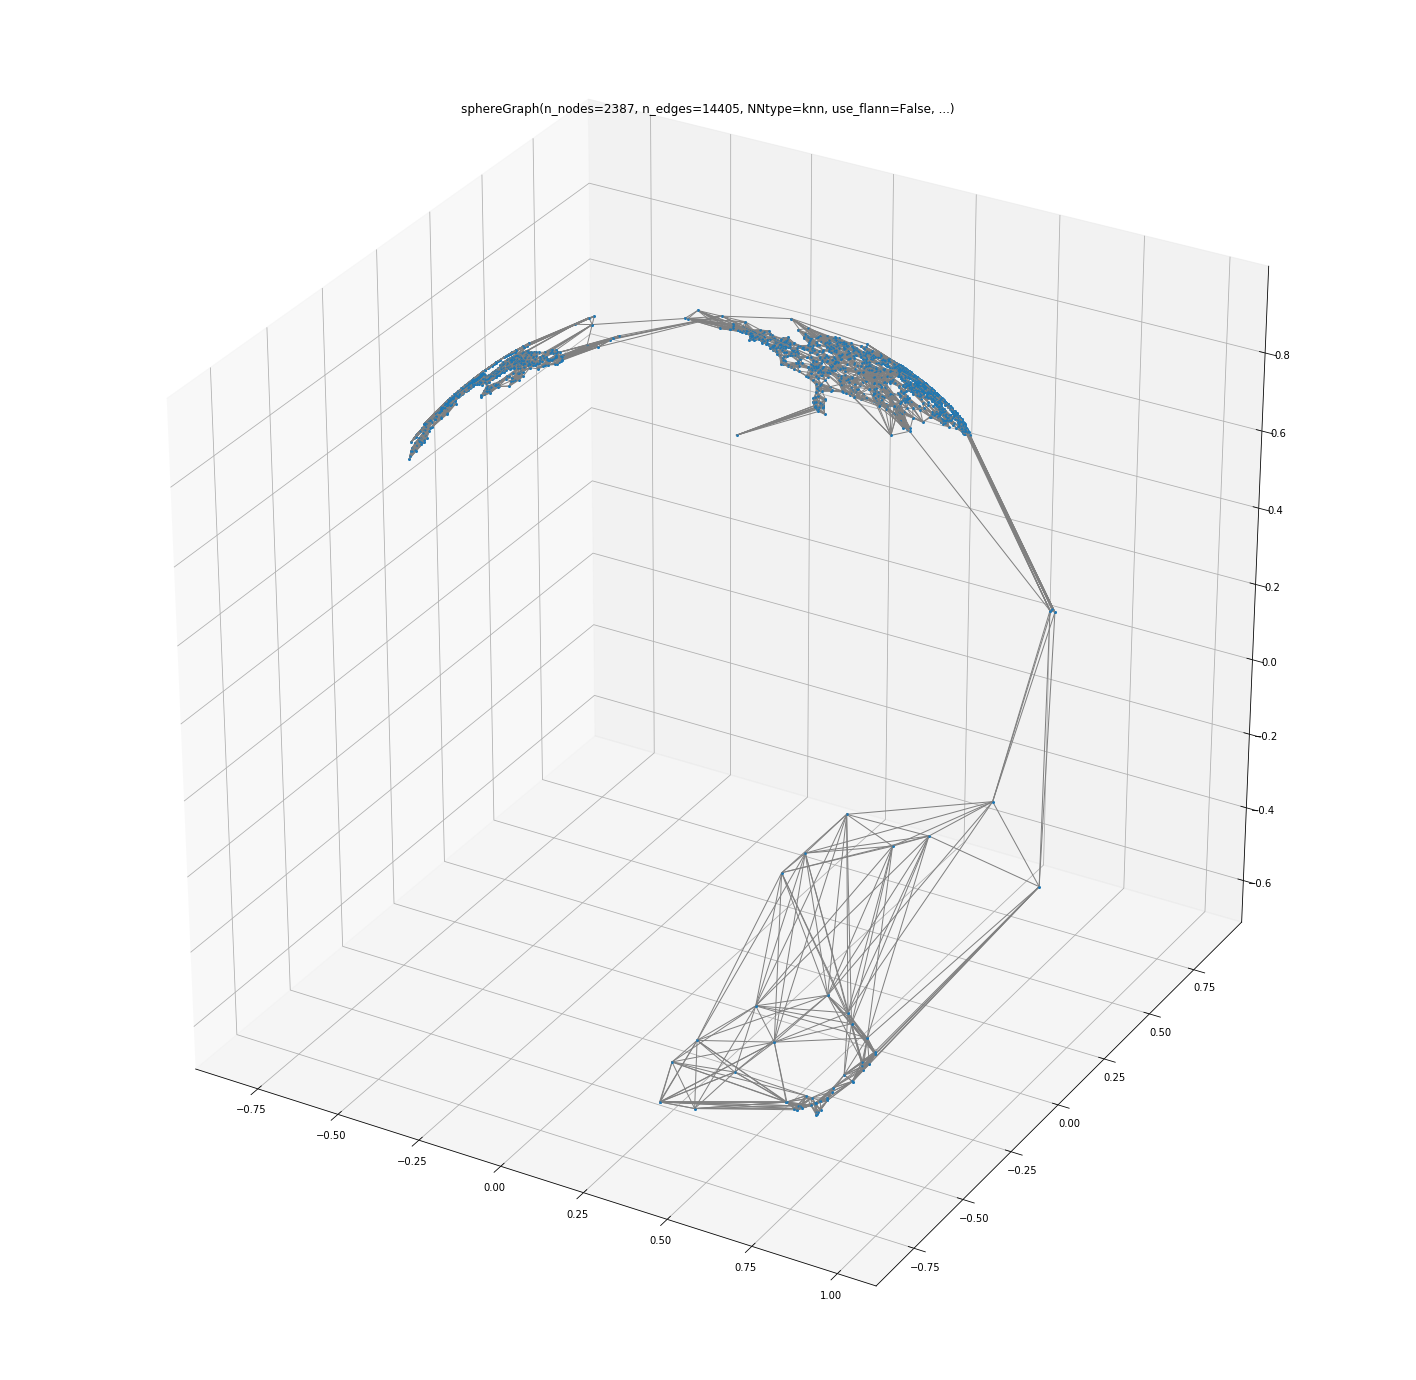

In [42]:
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

fig2 = plt.figure(figsize=(25,25))
axes = fig2.add_subplot(111, projection='3d')
gTemp = sphereGraph(lon[keepToo], lat[keepToo], 10, rad=False)
gTemp.plot(vertex_size=10, edges=True, ax=axes)
gTemp.compute_laplacian("combinatorial")

In [28]:
## temp max from temp min

ratio = 0.7
n_days = dataset_temp.shape[0]
limit= int(ratio*n_days)

x_train = dataset_temp[:limit,:,0]
labels_train = dataset_temp[:limit,:,1]
x_val = dataset_temp[limit:,:,0]
labels_val = dataset_temp[limit:,:,1]


training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

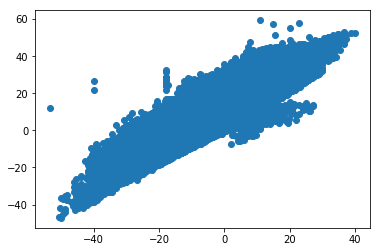

In [245]:
plt.scatter(x_val, labels_val)

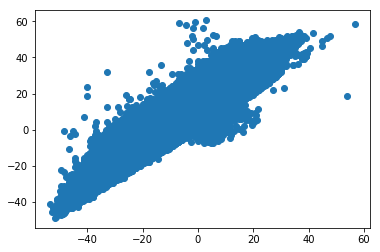

In [246]:
plt.scatter(x_train, labels_train)

Precipirtation from temperatures (MIN, MAX)

In [ ]:
## precipitation from temp
dataset = data.transpose((1, 0, 2))

ratio = 0.8
n_days = dataset.shape[0]
limit= int(ratio*n_days)

x_train = dataset[:limit,:,1:3]
labels_train = dataset[:limit,:,0]
x_val = dataset[limit:,:,1:3]
labels_val = dataset[limit:,:,0]


training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [54]:
valid_days[31+28::12*31]

array([False, False,  True, False, False])

In [81]:
w_months = np.tile(np.repeat(np.arange(12), 31), years[-1]-years[0]+1)[valid_days]
w_days = np.tile(np.arange(365),years[-1]-years[0])
w_days = np.insert(w_days, (3*365), 365)

In [89]:
## temp future (regression)
dataset = data.transpose((1, 0, 2))[:,:,1:3]

days_pred = 6

dataset_x = np.vstack([np.roll(dataset, -i, axis=0) for i in range(days_pred)])
dataset_x = dataset_x.reshape(days_pred, n_days, n_stations, 2).transpose((1,2,3,0))

month_x = np.vstack([np.roll(w_months, -i, axis=0) for i in range(days_pred)])
month_x = month_x.reshape(days_pred, n_days).transpose()

x_train = dataset_x[:n_days-days_pred-1,:,0,:]
labels_train = dataset[days_pred+1:,:,0]
x_val = dataset_x[:n_days-days_pred-1,:,1,:]
labels_val = dataset[days_pred+1:,:,1]

# can include information on which period we are? month?
x_train = np.stack([x_train, np.broadcast_to(month_x[:n_days-days_pred-1,np.newaxis, :], x_train.shape)], axis=-1)

# training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [269]:
import tensorflow as tf
params = {'L': [gTemp.L.astype(np.float32)]*4,
          'p': [1,1,1,1],
          'F': [10, 20, 50, 1],
          'K': [3]*4,
          'batch_norm': [True]*4}
EXP_NAME = params['dir_name'] = 'GHCN_essai'
params['num_feat_in'] = 1
params['conv'] = 'chebyshev5'
params['pool'] = 'max'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 200  # Number of passes through the training data.
params['batch_size'] = 32
params['scheduler'] = lambda step: tf.train.exponential_decay(5e3, step, decay_steps=5, decay_rate=1)
params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
n_evaluations = 200
params['eval_frequency'] = int(params['num_epochs'] * limit / params['batch_size'] / n_evaluations)
params['M'] = []
params['regression']=True
model = models.cgcnn(**params)

NN architecture
  input: M_0 = 2387
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 2387 * 10 / 1 = 23870
    weights: F_0 * F_1 * K_1 = 1 * 10 * 3 = 30
    biases: F_1 = 10
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 2387 * 20 / 1 = 47740
    weights: F_1 * F_2 * K_2 = 10 * 20 * 3 = 600
    biases: F_2 = 20
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 2387 * 50 / 1 = 119350
    weights: F_2 * F_3 * K_3 = 20 * 50 * 3 = 3000
    biases: F_3 = 50
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 2387 * 1 / 1 = 2387
    weights: F_3 * F_4 * K_4 = 50 * 1 * 3 = 150
    batch normalization


In [149]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [271]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(training, validation)

step 57 / 7987 (epoch 1.43 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.98e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 4s, wall time: 6s, perf_time_load: 0.056s, perf_time: 0.000s
step 114 / 7987 (epoch 2.85 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.56e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 6s, wall time: 11s, perf_time_load: 0.065s, perf_time: 0.000s
step 171 / 7987 (epoch 4.28 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.20e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 8s, wall time: 15s, perf_time_load: 0.058s, perf_time: 0.000s
step 228 / 7987 (epoch 5.71 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.75e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 10s, wal

step 1824 / 7987 (epoch 45.67 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.72e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 63s, wall time: 129s, perf_time_load: 0.061s, perf_time: 0.000s
step 1881 / 7987 (epoch 47.10 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.22e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 65s, wall time: 132s, perf_time_load: 0.056s, perf_time: 0.000s
step 1938 / 7987 (epoch 48.53 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.56e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 67s, wall time: 136s, perf_time_load: 0.065s, perf_time: 0.000s
step 1995 / 7987 (epoch 49.95 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 4.09e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CP

step 3591 / 7987 (epoch 89.92 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.69e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 123s, wall time: 247s, perf_time_load: 0.057s, perf_time: 0.000s
step 3648 / 7987 (epoch 91.34 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 4.08e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 125s, wall time: 251s, perf_time_load: 0.056s, perf_time: 0.000s
step 3705 / 7987 (epoch 92.77 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.20e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 127s, wall time: 254s, perf_time_load: 0.056s, perf_time: 0.000s
step 3762 / 7987 (epoch 94.20 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.38e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
 

  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 180s, wall time: 359s, perf_time_load: 0.057s, perf_time: 0.000s
step 5358 / 7987 (epoch 134.16 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.71e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 182s, wall time: 363s, perf_time_load: 0.057s, perf_time: 0.000s
step 5415 / 7987 (epoch 135.59 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.71e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 184s, wall time: 366s, perf_time_load: 0.057s, perf_time: 0.000s
step 5472 / 7987 (epoch 137.01 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 4.15e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 186s, wall time: 370s, perf_time_load: 0.057s, perf_time: 0.000s
step 5529 / 7987 (epoch 138.44 / 200)

step 7068 / 7987 (epoch 176.98 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.23e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 239s, wall time: 476s, perf_time_load: 0.075s, perf_time: 0.000s
step 7125 / 7987 (epoch 178.40 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 2.96e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 241s, wall time: 480s, perf_time_load: 0.058s, perf_time: 0.000s
step 7182 / 7987 (epoch 179.83 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 3.86e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+02
  CPU time: 243s, wall time: 484s, perf_time_load: 0.058s, perf_time: 0.000s
step 7239 / 7987 (epoch 181.26 / 200):
  learning_rate = 5.00e+03, training accuracy = nan, training loss = 4.18e+02
  validation explained variance: 0.0000, r2: -7.5374, loss (MSE): 3.837e+

## regression problem

# pooling the graph

## pyGSP reduction

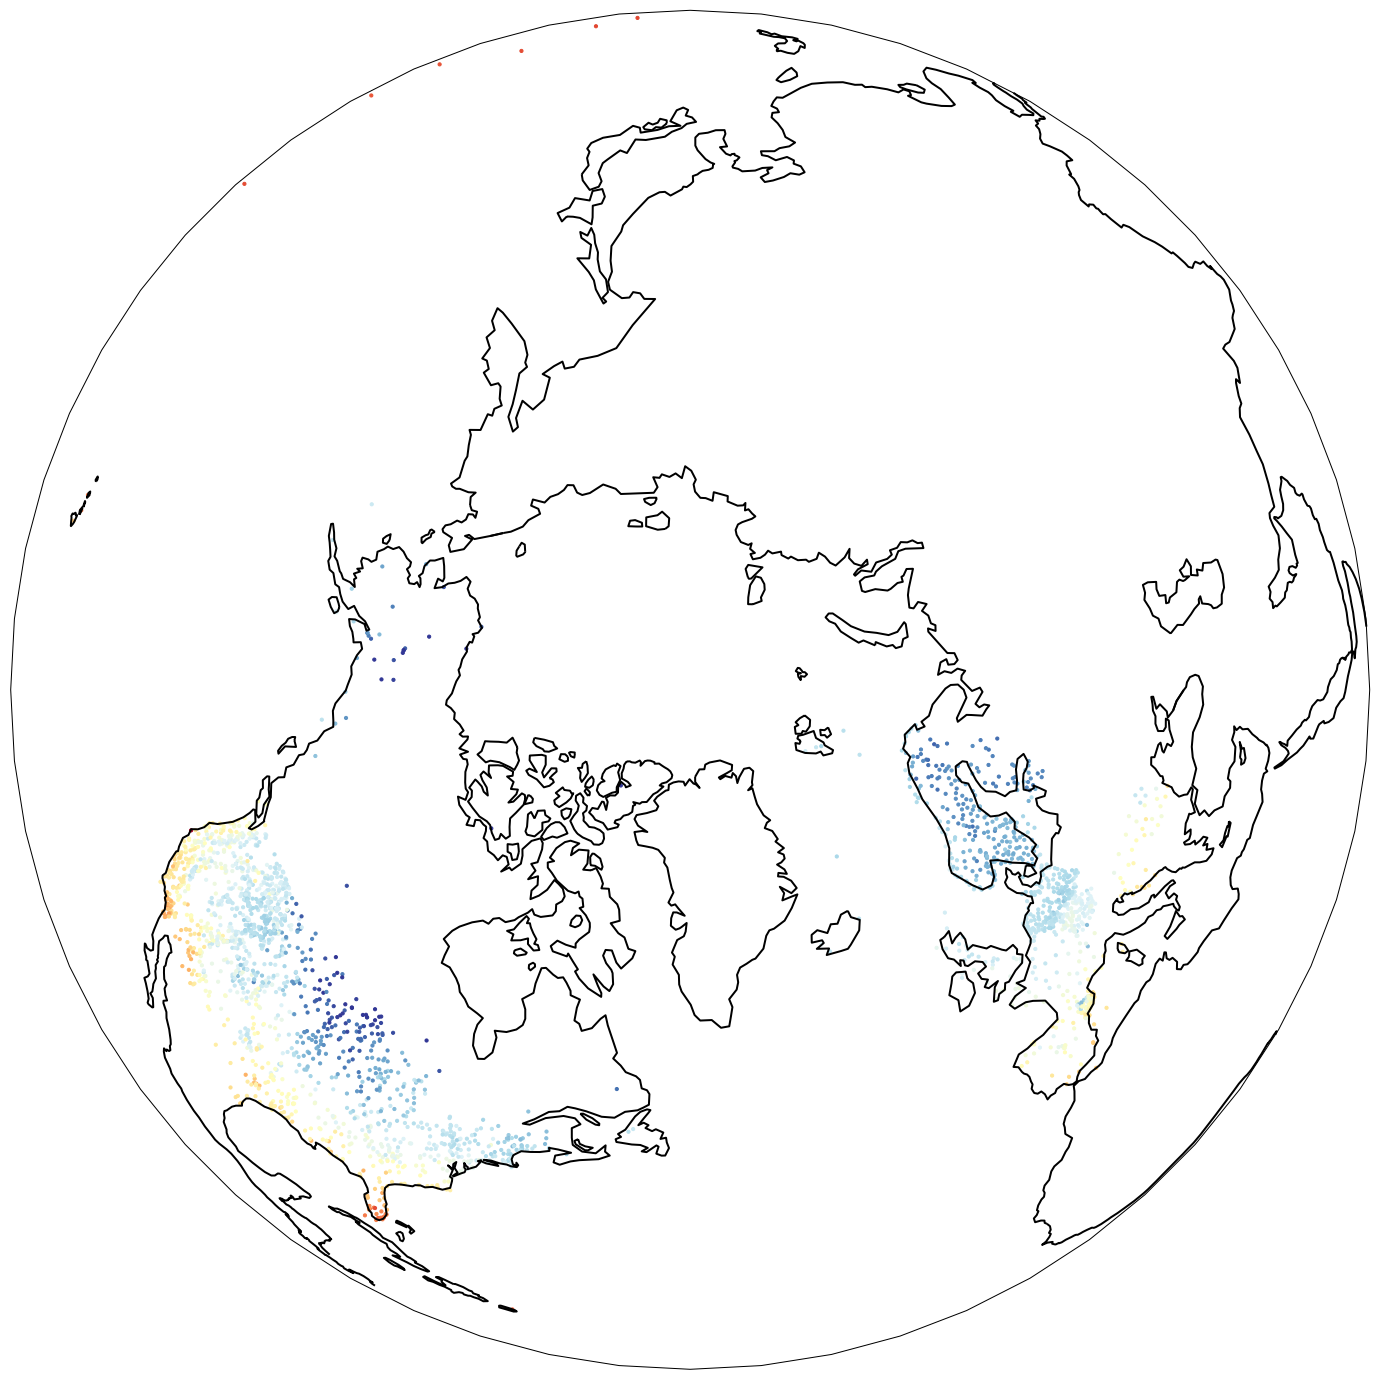

In [40]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)

zmin, zmax = -20, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(full_data[keepToo, 0, 2], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

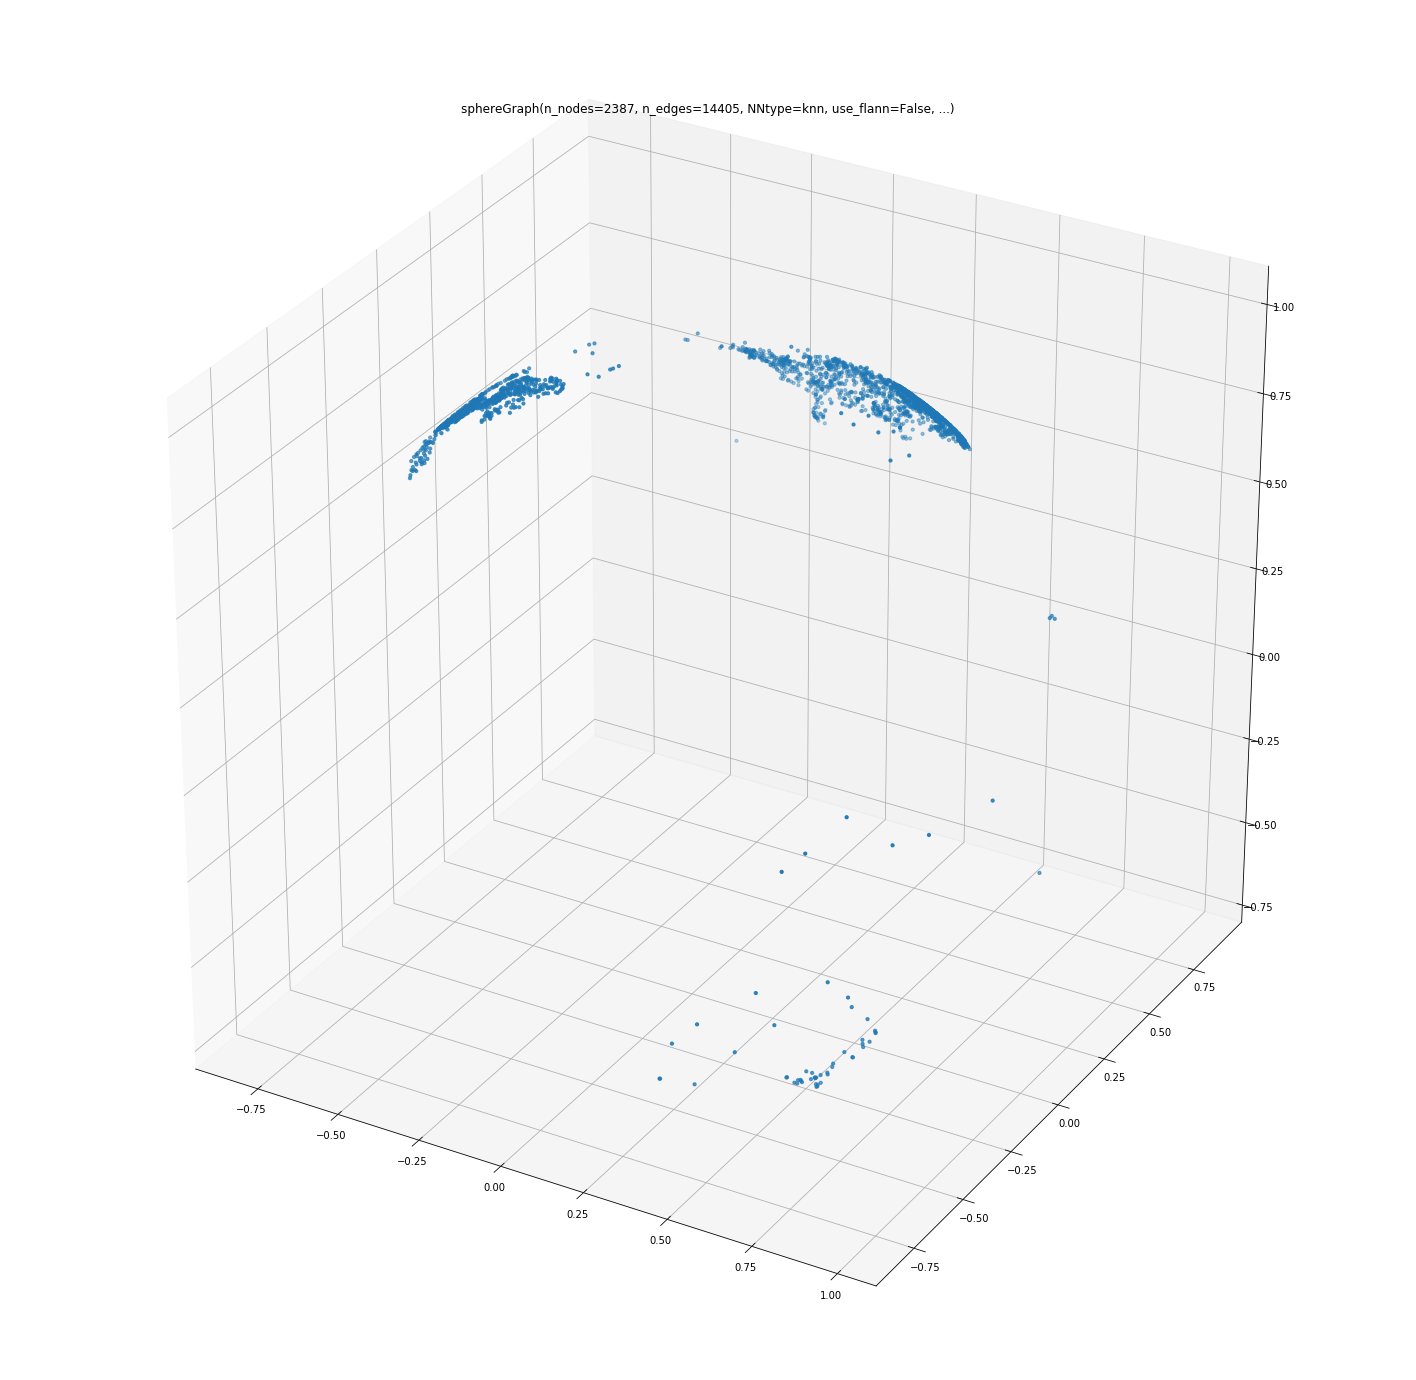

In [35]:
fig2 = plt.figure(figsize=(25,25))
axes = fig2.add_subplot(111, projection='3d')
gTemp.plot(vertex_size=10, ax = axes)

In [50]:
gTemp.coords

array([[ 0.95618553,  0.15634834, -0.2475165 ],
       [ 0.507442  , -0.8047043 , -0.30814541],
       [ 0.43932046, -0.81468675, -0.37852746],
       ...,
       [ 0.1112659 ,  0.75102392,  0.65083252],
       [ 0.0745572 ,  0.76150165,  0.64386059],
       [ 0.04128512,  0.70513487,  0.7078703 ]])

In [52]:
from pygsp import reduction
levels = 2
#gTemp.compute_laplacian('combinatorial')
#gTemp.compute_fourier_basis(n_eigenvectors=500)
Gs = reduction.graph_multiresolution(gTemp, levels, sparsify=True)
for idx in range(levels):
    Gs[idx].plotting['plot_name'] = 'Reduction level: {}'.format(idx)
    Gs[idx].plot()

AttributeError: 'Graph' object has no attribute 'coords'

## area pixel

In [53]:
import healpy as hp

In [99]:
pool = 'max' # in ['max', 'mean', ...]
Nside = 64
theta = lon[keepToo]#np.deg2rad(lon[keepToo])
phi = lat[keepToo]#np.deg2rad(lat[keepToo])
# dataset_temp
pix, weights = hp.get_interp_weights(Nside, theta, phi, nest=True, lonlat=True)
indexes = np.unique(pix)
size = dataset_temp.shape
size = list(size)
size[1] = len(indexes) # hp.nside2npix(Nside)
size = tuple(size)
new_map = np.zeros(size)
# new_map[new_map==0] = hp.UNSEEN
pool_fun = getattr(np, pool)
for i, index in enumerate(indexes):
    pl = np.where(pix==index)
    wght = weights[pl]
    data_p = dataset_temp[:, pl[1], :]
    new_map[:,i,:] = pool_fun(data_p, axis=1)
new_lon, new_lat = hp.pix2ang(Nside, indexes, nest=True, lonlat=True)

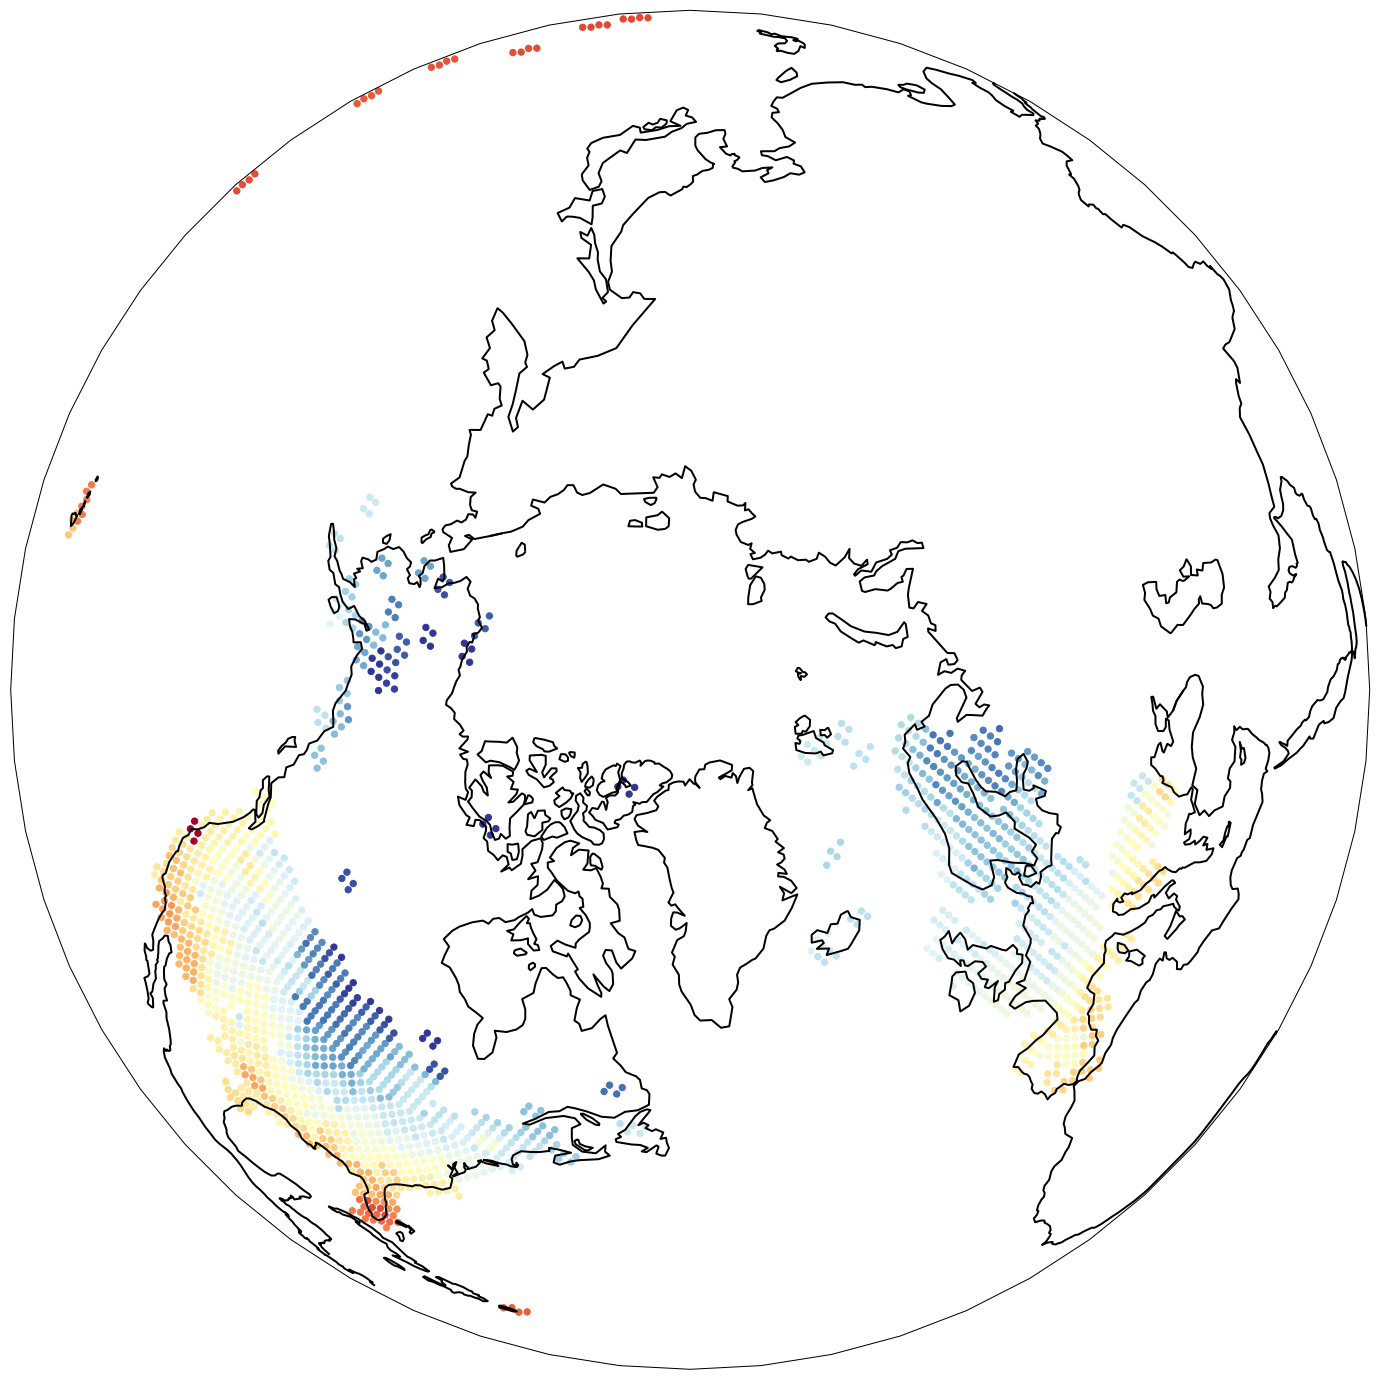

In [100]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)

zmin, zmax = -20, 40

sc = ax.scatter(new_lon, new_lat, s=40,
                c=np.clip(new_map[0, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

## NNeighbours

### use knn graph

Separate in cluser, and merge them???

In [ ]:
k = 5
gTemp_1 = sphereGraph(lon[keepToo], lat[keepToo], k, rad=False)
gTemp_1.plot()
gTemp_1.compute_laplacian('normalized')
gTemp_1.compute_fourier_basis(n_eigenvectors=1000)

In [ ]:
NCluster = dataset_temp.shape[1]//5


In [ ]:
plt.plot(gTemp_1.e[:16], 'o')

### compute knn ourselves (geodesic distances)